# Import libraries

In [2]:
from google.colab import drive
# Mount drive from Google
drive.mount('/content/gdrive')

import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Subset, DataLoader
from random import shuffle
import time
import pickle

# if not torch.cuda.is_available():
#     raise SystemError("GPU device not found, selection Runtime -> Change runtime type")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Define parameters

In [3]:
# Define dictionary of parameters and hyper parametes
args = {
    'lr_classifier': 1e-3,
    'lr_generator': 0.0002,
    'lr_discriminator': 0.0002,
    'bs': 128,
    'epochs_classifier': 2,
    'epochs_gan': 2,
    'num_tasks': 5,
    'dataset': "MNIST",
    'num_classes': 10,
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 50,
    'latent_dim': 100
}

# Main path
root_path = '/content/gdrive/MyDrive/PhD_Data_Science/courses_and_seminars/Deep generative view on continual learning/assignment/'
%cd $root_path

/content/gdrive/MyDrive/PhD_Data_Science/courses_and_seminars/Deep generative view on continual learning/assignment


# Define classes and functions

In [4]:
import random

def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.1307), (0.3081)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std)])

    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, val_dataset

def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array

def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()

def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=f"Task {e}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc

def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt

def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

class Generator(torch.nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.BatchNorm1d(256, 0.8),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.BatchNorm1d(512, 0.8),
            torch.nn.ReLU(),
            torch.nn.Linear(512, int(np.prod(img_shape))),
            torch.nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

class Discriminator(torch.nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(int(np.prod(img_shape)), 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

class Agent:
    def __init__(self, args, train_datasets, val_datasets):
        self.args = args
        self.model = MLP(self.args)
        if torch.cuda.is_available():
            self.model.cuda()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr_classifier'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets

        self.latent_dim = args['latent_dim']
        self.img_shape = (args['n_channels'], args['in_size'], args['in_size'])

        self.generator = Generator(self.latent_dim, self.img_shape)
        self.discriminator = Discriminator(self.img_shape)
        self.adversarial_loss = torch.nn.BCELoss()

        if torch.cuda.is_available():
            self.generator.cuda()
            self.discriminator.cuda()
            self.adversarial_loss.cuda()

    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}

    def train_gan(self, task_loader, task):
        optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.args['lr_generator'])
        optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.args['lr_discriminator'])

        for epoch in range(self.args['epochs_gan']):
            for i, (imgs, _) in enumerate(task_loader):
                batch_size = imgs.size(0)

                valid = torch.ones(batch_size, 1, requires_grad=False)
                fake = torch.zeros(batch_size, 1, requires_grad=False)
                if torch.cuda.is_available():
                    valid, fake = valid.cuda(), fake.cuda()

                real_imgs = imgs
                if torch.cuda.is_available():
                    real_imgs = real_imgs.cuda()

                optimizer_G.zero_grad()
                z = torch.randn(batch_size, self.latent_dim)
                if torch.cuda.is_available():
                    z = z.cuda()
                gen_imgs = self.generator(z)
                g_loss = self.adversarial_loss(self.discriminator(gen_imgs), valid)
                g_loss.backward()
                optimizer_G.step()

                optimizer_D.zero_grad()
                real_loss = self.adversarial_loss(self.discriminator(real_imgs), valid)
                fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()

            print(f"Task {task} | Epoch {epoch} | D loss: {d_loss.item()} | G loss: {g_loss.item()}")

        # visualize_generated_images(self, num_images=10)  # Visualize generated images after training the GAN

    def replay_data(self, num_samples):
        z = torch.randn(num_samples, self.latent_dim)
        if torch.cuda.is_available():
            z = z.cuda()
        with torch.no_grad():
            gen_imgs = self.generator(z).detach()
            # Use the current model to predict labels for the generated images
            replay_labels = torch.argmax(self.model(gen_imgs), dim=1)
        return gen_imgs, replay_labels

    def train(self):
        replay_datasets = []
        replay_labels_list = []

        self.memory_usage = []
        self.computation_times = []

        for task, data in self.train_datasets.items():
            task_loader = DataLoader(data, batch_size=self.args['bs'], shuffle=True)

            # Measure memory and computation time for GAN training
            start_time = time.time()
            # self.train_gan(task_loader, task)

            for epoch in range(self.args['epochs_classifier']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(task_loader):
                    if torch.cuda.is_available():
                        X, y = X.cuda(), y.cuda()

                    # Concatenate replay data from previous tasks with original data
                    if replay_datasets:
                        # Concatenate all replay datasets up to the current task
                        replay_data = torch.cat(replay_datasets, dim=0)
                        # Concatenate all replay labels up to the current task
                        replay_labels = torch.cat(replay_labels_list, dim=0)
                        replay_data = replay_data.to(X.device)
                        replay_labels = replay_labels.to(y.device)
                        X_replay = torch.cat([X, replay_data], dim=0)
                        y_replay = torch.cat([y, replay_labels], dim=0)
                        if torch.cuda.is_available():
                            X_replay, y_replay = X_replay.cuda(), y_replay.cuda()
                    else:
                        X_replay, y_replay = X, y

                    # Forward pass
                    output = self.model(X_replay)
                    loss = self.criterion(output, y_replay.long())
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y_replay.long())
                    total += len(X_replay)

                    if e % 50 == 0:
                        self.validate()

                print(f"Task {task} | Epoch {epoch}: Loss {epoch_loss/(e+1):.3f} Acc: {correct/total:.3f}")

            self.validate(end_of_epoch=True)
            # Store replay data and labels after each task
            inds = list(range(1, len(task_loader.dataset)))
            replay_data = torch.Tensor(np.array(list(map(lambda x: np.copy(task_loader.dataset[x][0]), inds))))
            replay_labels = torch.LongTensor(np.array(list(map(lambda x: np.copy(task_loader.dataset[x][1]), inds))))
            print(replay_data.cpu().numpy().shape)
            # print(type(replay_data))
            # print(type(replay_labels))
            replay_data = replay_data.to(next(self.model.parameters()).device)
            replay_labels = replay_labels.to(next(self.model.parameters()).device)
            replay_datasets.append(replay_data)
            replay_labels_list.append(replay_labels)
            end_time = time.time()
            self.computation_times.append(end_time - start_time)
            if torch.cuda.is_available():
                self.memory_usage.append(torch.cuda.memory_allocated())

        print("Memory usage (in bytes):", self.memory_usage)
        print("Computation times (in seconds):", self.computation_times)

    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=self.args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                if torch.cuda.is_available():
                    X, y = X.cuda(), y.cuda()
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()


class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# def visualize_generated_images(agent, num_images):
#     device = next(agent.model.parameters()).device  # Get the device of the model parameters
#     z = torch.randn(num_images, agent.latent_dim, device=device)  # Move z to the same device
#     with torch.no_grad():
#         gen_imgs = agent.generator(z).detach().to(device)  # Move generated images to the same device
#         predicted_labels = torch.argmax(agent.model(gen_imgs), dim=1)

#     gen_imgs = gen_imgs.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to numpy for visualization

#     fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
#     for i, ax in enumerate(axes):
#         ax.imshow(gen_imgs[i].squeeze(), cmap='gray')
#         ax.set_title(f"Label: {predicted_labels[i].item()}")
#         ax.axis('off')
#     plt.show()

# Train vanilla replay for CL


## Load and preprocess data

In [5]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

## Fit vanila replay

In [6]:
# Set flag to train or load model
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = False

if load_model:
  # Load model
  infile = open(root_path + '/agent.pkl','rb')
  agent = pickle.load(infile)
  infile = open(root_path + '/random_model_acc.pkl','rb')
  random_model_acc = pickle.load(infile)

else:
  agent = Agent(args, train_tasks, val_tasks)
  agent.validate()
  random_model_acc = [i[0] for i in agent.acc.values()]
  agent.reset_acc()
  agent.train()

  #Save model
  # with open(root_path + '/agent.pkl', 'wb') as pickfile:
  #     pickle.dump(agent, pickfile)
  # with open(root_path + '/random_model_acc.pkl', 'wb') as pickfile:
  #   pickle.dump(random_model_acc, pickfile)

Task 0 | Epoch 0: Loss 0.437 Acc: 0.902
Task 0 | Epoch 1: Loss 0.086 Acc: 0.970
(11271, 1, 28, 28)
Task 1 | Epoch 0: Loss 0.102 Acc: 0.974
Task 1 | Epoch 1: Loss 0.035 Acc: 0.991
(12699, 1, 28, 28)
Task 2 | Epoch 0: Loss 0.118 Acc: 0.967
Task 2 | Epoch 1: Loss 0.049 Acc: 0.987
(12048, 1, 28, 28)
Task 3 | Epoch 0: Loss 0.153 Acc: 0.955
Task 3 | Epoch 1: Loss 0.065 Acc: 0.982
(12187, 1, 28, 28)
Task 4 | Epoch 0: Loss 0.110 Acc: 0.969
Task 4 | Epoch 1: Loss 0.062 Acc: 0.983
(11790, 1, 28, 28)
Memory usage (in bytes): []
Computation times (in seconds): [26.835844039916992, 48.97068476676941, 80.65408134460449, 111.06618928909302, 130.8444504737854]


## Check performance results

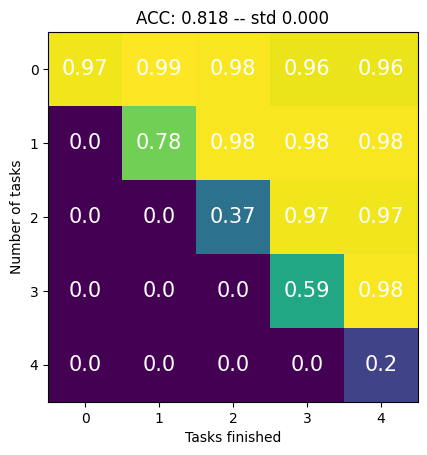

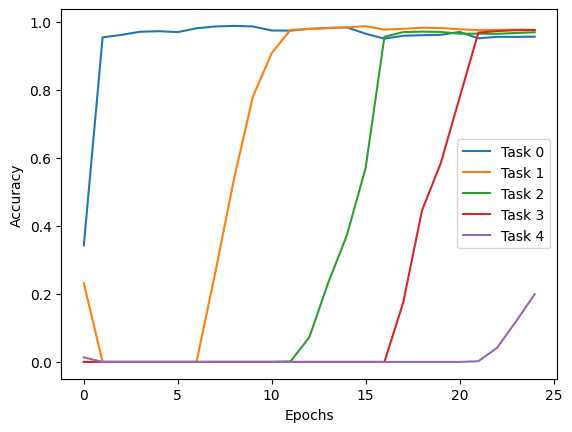

The average accuracy at the end of sequence is: 0.816
BWT:'0.292'
FWT:'-0.100'


In [7]:
acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

## Check time complexity and memory overhead

In [8]:
# Metrics obtained from vanilla replay to compare
print(f"Memory usage for vanilla replay (in GB): {np.sum(agent.memory_usage)/(1024 * 1024 * 1024):.3f}")
print(f"Memory usage for vanilla replay (in minutes): {np.sum(agent.computation_times)/(60):.3f}")

Memory usage for vanilla replay (in GB): 0.000
Memory usage for vanilla replay (in minutes): 6.640
